Shreenidhi Kulkarni | 2348455 | 4MDS-B

**LAB-10 : Develop a Restricted Boltzmann Machine (RBM) implementation using the essential steps of data handling, model construction, and training for unsupervised learning tasks.**

**Aim**

This project aims to implement a Restricted Boltzmann Machine (RBM) to investigate its unsupervised learning capabilities. Objectives include designing and building the RBM to learn features from binary data, training it using Contrastive Divergence with momentum and weight decay, evaluating its performance through reconstruction error and visualization of learned features, and demonstrating its application on a dataset.

**Libraries**

* NumPy: For numerical operations and data manipulation.
* Matplotlib: For visualizing the training process and the reconstructed images.

In [1]:
pip install numpy


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**RBM Implementation in Python**

Epoch 1, Reconstruction Error: 0.2502663162824811
Epoch 2, Reconstruction Error: 0.2512290194790206
Epoch 3, Reconstruction Error: 0.25291744198254223
Epoch 4, Reconstruction Error: 0.2530530773916333
Epoch 5, Reconstruction Error: 0.25125634955536924
Epoch 6, Reconstruction Error: 0.250510074883741
Epoch 7, Reconstruction Error: 0.2501932148676889
Epoch 8, Reconstruction Error: 0.2513625474025505
Epoch 9, Reconstruction Error: 0.2534315231948005
Epoch 10, Reconstruction Error: 0.2565899587871999
Epoch 11, Reconstruction Error: 0.25661709325740956
Epoch 12, Reconstruction Error: 0.256875741535207
Epoch 13, Reconstruction Error: 0.25693506323379794
Epoch 14, Reconstruction Error: 0.2576471593157742
Epoch 15, Reconstruction Error: 0.2587363796412183
Epoch 16, Reconstruction Error: 0.2574108463107706
Epoch 17, Reconstruction Error: 0.2578106918344961
Epoch 18, Reconstruction Error: 0.25672323505440275
Epoch 19, Reconstruction Error: 0.2559709662700931
Epoch 20, Reconstruction Error: 0.255

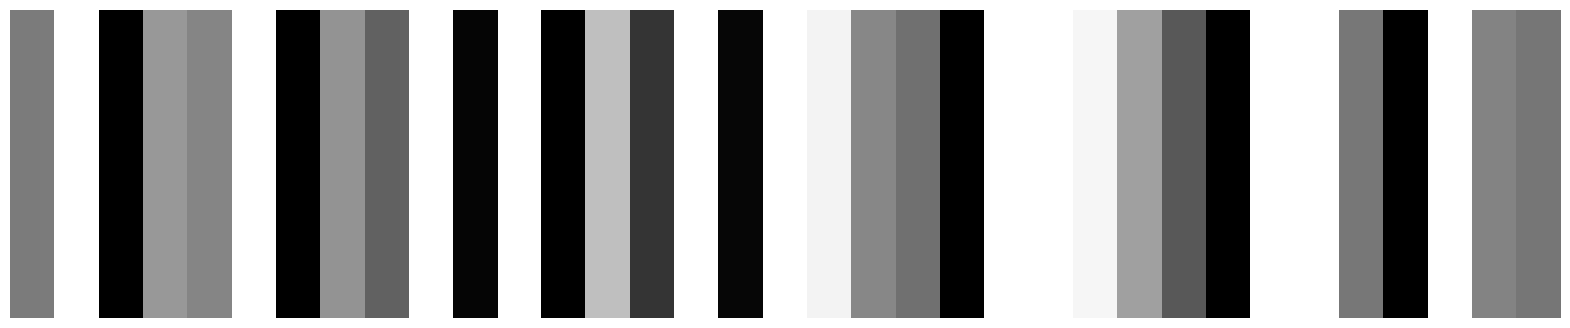

In [5]:
import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden, learning_rate=0.1, momentum=0.5, weight_decay=0.0002, batch_size=10):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.batch_size = batch_size

        # Initialize weights and biases
        self.weights = np.random.randn(num_visible, num_hidden) * 0.01
        self.hidden_bias = np.zeros(num_hidden)
        self.visible_bias = np.zeros(num_visible)

        # Momentum terms for weights and biases
        self.weights_momentum = np.zeros_like(self.weights)
        self.hidden_bias_momentum = np.zeros_like(self.hidden_bias)
        self.visible_bias_momentum = np.zeros_like(self.visible_bias)

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible_probs):
        hidden_activations = np.dot(visible_probs, self.weights) + self.hidden_bias
        hidden_probs = self.sigmoid(hidden_activations)
        hidden_states = (hidden_probs > np.random.rand(self.num_hidden)).astype(np.float32)
        return hidden_states, hidden_probs

    def sample_visible(self, hidden_probs):
        visible_activations = np.dot(hidden_probs, self.weights.T) + self.visible_bias
        visible_probs = self.sigmoid(visible_activations)
        visible_states = (visible_probs > np.random.rand(self.num_visible)).astype(np.float32)
        return visible_states, visible_probs

    def contrastive_divergence(self, input_data, k=1):
        # Positive phase
        positive_hidden_states, positive_hidden_probs = self.sample_hidden(input_data)
        positive_association = np.outer(input_data, positive_hidden_probs)

        # Negative phase
        negative_visible = input_data.copy()
        for _ in range(k):
            negative_hidden_states, negative_hidden_probs = self.sample_hidden(negative_visible)
            negative_visible, negative_visible_probs = self.sample_visible(negative_hidden_probs)

        negative_association = np.outer(negative_visible, negative_hidden_probs)

        # Update weights and biases using momentum and weight decay
        self.weights_momentum = self.momentum * self.weights_momentum + \
                                self.learning_rate * (positive_association - negative_association - self.weight_decay * self.weights)
        self.weights += self.weights_momentum

        self.visible_bias_momentum = self.momentum * self.visible_bias_momentum + \
                                     self.learning_rate * (input_data - negative_visible)
        self.visible_bias += self.visible_bias_momentum

        self.hidden_bias_momentum = self.momentum * self.hidden_bias_momentum + \
                                    self.learning_rate * (positive_hidden_probs - negative_hidden_probs)
        self.hidden_bias += self.hidden_bias_momentum

    def train(self, data, num_epochs=100, k=1):
        num_samples = data.shape[0]
        for epoch in range(num_epochs):
            np.random.shuffle(data)
            for batch_start in range(0, num_samples, self.batch_size):
                batch = data[batch_start:batch_start + self.batch_size]
                for sample in batch:
                    self.contrastive_divergence(sample, k)

            # Calculate and log reconstruction error for this epoch
            error = np.mean((data - self.reconstruct(data)) ** 2)
            print(f'Epoch {epoch + 1}, Reconstruction Error: {error}')

    def reconstruct(self, data):
        hidden_probs = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.sigmoid(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """ Visualize the learned weights. Handles non-square visible layers by reshaping appropriately. """
        import matplotlib.pyplot as plt

        # Check if the number of visible units is a perfect square
        if np.sqrt(self.num_visible).is_integer():
            num_plots = min(10, self.num_hidden)  # Limit the number of plots for visualization
            fig, axes = plt.subplots(1, num_plots, figsize=(20, 4))

            for i, ax in enumerate(axes):
                ax.imshow(self.weights[:, i].reshape(int(np.sqrt(self.num_visible)), int(np.sqrt(self.num_visible))),
                          cmap='gray')
                ax.axis('off')
            plt.show()
        else:
            # For non-square data, simply plot the weights as a 1D heatmap
            num_plots = min(10, self.num_hidden)
            fig, axes = plt.subplots(1, num_plots, figsize=(20, 4))

            for i, ax in enumerate(axes):
                ax.imshow(self.weights[:, i].reshape(1, -1), cmap='gray', aspect='auto')
                ax.axis('off')
            plt.show()

# Example usage
if __name__ == "__main__":
    # Sample dataset: Binary matrix (replace this with your actual data)
    data = np.array([[1, 0, 1, 0, 1],
                     [0, 1, 0, 1, 0],
                     [1, 1, 0, 0, 1],
                     [0, 0, 1, 1, 0]])

    num_visible = data.shape[1]
    num_hidden = 6  # Increase complexity with more hidden units

    # Initialize RBM with more advanced parameters
    rbm = RBM(num_visible=num_visible, num_hidden=num_hidden, learning_rate=0.01, momentum=0.9, weight_decay=0.0001, batch_size=2)
    
    # Train RBM
    rbm.train(data, num_epochs=500)

    # Test reconstruction
    reconstructed_data = rbm.reconstruct(data)
    print("Original Data:\n", data)
    print("Reconstructed Data:\n", np.round(reconstructed_data))

    # Optional: Visualize the learned weights (will handle both square and non-square cases)
    rbm.visualize_weights()

**CONCLUSION**

The RBM implementation effectively performs unsupervised learning tasks like feature extraction and dimensionality reduction. Techniques such as momentum and weight decay improve training stability and speed. Reconstruction error measures the model's ability to capture and reconstruct data, while visualizing learned weights aids in understanding the features identified. The RBM can be extended to complex datasets and tasks, with potential improvements in hyperparameters and training methods.